In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,accuracy_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.layers import TimeDistributed, Flatten, Reshape, Dropout, RepeatVector


In [2]:
np.random.seed(42)
tf.random.set_seed(42)


In [3]:
col_names = [
        'duration', 'protocol_type', 'service', 'flag', 'src_bytes',
        'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
        'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
        'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
        'num_access_files', 'num_outbound_cmds', 'is_host_login',
        'is_guest_login', 'count', 'srv_count', 'serror_rate',
        'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
        'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
        'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
        'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
        'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
        'dst_host_srv_rerror_rate', 'attack', 'level'
    ]

train_df = pd.read_csv(r"C:\Users\Rajat Dhanure\Downloads\CN SCE\dataset\KDDTrain+.txt\KDDTrain+.txt", header=None, names=col_names)
test_df = pd.read_csv(r"C:\Users\Rajat Dhanure\Downloads\CN SCE\dataset\KDDTest+.txt\KDDTest+.txt", header=None, names=col_names)

In [4]:
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (125973, 43)
Testing data shape: (22544, 43)


In [5]:
train_df['binary_label'] = train_df['attack'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['binary_label'] = test_df['attack'].apply(lambda x: 0 if x == 'normal' else 1)

In [6]:
train_normal = train_df[train_df['binary_label'] == 0]
train_attack = train_df[train_df['binary_label'] == 1]

In [7]:
print(f"Normal training samples: {len(train_normal)}")
print(f"Attack training samples: {len(train_attack)}")

Normal training samples: 67343
Attack training samples: 58630


In [8]:
features = train_df.columns.drop(['attack', 'level', 'binary_label'])

In [9]:
categorical_columns = ['protocol_type', 'service', 'flag']
numerical_columns = [col for col in features if col not in categorical_columns]

# Apply one-hot encoding to categorical columns
train_categorical = pd.get_dummies(train_df[categorical_columns])
test_categorical = pd.get_dummies(test_df[categorical_columns])

In [10]:
missing_cols = set(train_categorical.columns) - set(test_categorical.columns)
for col in missing_cols:
    test_categorical[col] = 0
test_categorical = test_categorical[train_categorical.columns]

In [11]:
scaler = MinMaxScaler()
train_numerical = pd.DataFrame(
    scaler.fit_transform(train_df[numerical_columns]),
    columns=numerical_columns
)
test_numerical = pd.DataFrame(
    scaler.transform(test_df[numerical_columns]),
    columns=numerical_columns
)

In [12]:
train_features = pd.concat([train_numerical, train_categorical], axis=1)
test_features = pd.concat([test_numerical, test_categorical], axis=1)

In [13]:
X_train_normal = train_features[train_df['binary_label'] == 0].values
X_test = test_features.values
y_test = test_df['binary_label'].values

In [14]:
X_train_normal = X_train_normal.astype('float32')
X_test = X_test.astype('float32')

In [15]:
print(f"X_train_normal dtype: {X_train_normal.dtype}")
print(f"X_test dtype: {X_test.dtype}")

X_train_normal dtype: float32
X_test dtype: float32


In [16]:
X_train_normal = X_train_normal.reshape(X_train_normal.shape[0], 1, X_train_normal.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(f"Training data shape after reshaping: {X_train_normal.shape}")
print(f"Testing data shape after reshaping: {X_test.shape}")

Training data shape after reshaping: (67343, 1, 122)
Testing data shape after reshaping: (22544, 1, 122)


In [17]:
timesteps=X_train_normal.shape[1]
features=X_train_normal.shape[2]

model = Sequential([
    LSTM(64, activation='relu', input_shape=(timesteps, features), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(timesteps),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(features))  # Output same shape as input
])

model.compile(optimizer='adam', loss='mse')
model.summary()


C:\Users\Rajat Dhanure\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 64)               │          47,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 32)               │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 1, 64)               │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 1, 122)              │           7,930 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,370 (395.98 KB)

 Trainable params: 101,370 (395.98 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
history = model.fit(X_train_normal, X_train_normal, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
842/842 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0238 - val_loss: 0.0037
Epoch 2/30
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 3/30
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 4/30
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.7463e-04 - val_loss: 7.8970e-04
Epoch 5/30
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.4765e-04 - val_loss: 6.5868e-04
Epoch 6/30
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.2206e-04 - val_loss: 5.6312e-04
Epoch 7/30
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.2550e-04 - val_loss: 4.9003e-04
Epoch 8/30
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.5302e-04 - val_loss: 4.3004e-04
Epoch 9/30
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.0363e-04 - val_loss: 3.9041e-04
Epoch 10/30
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6903e-04 - val_loss: 3.5620e-04
Epoch 11/30
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.4088e-04 - val_loss:

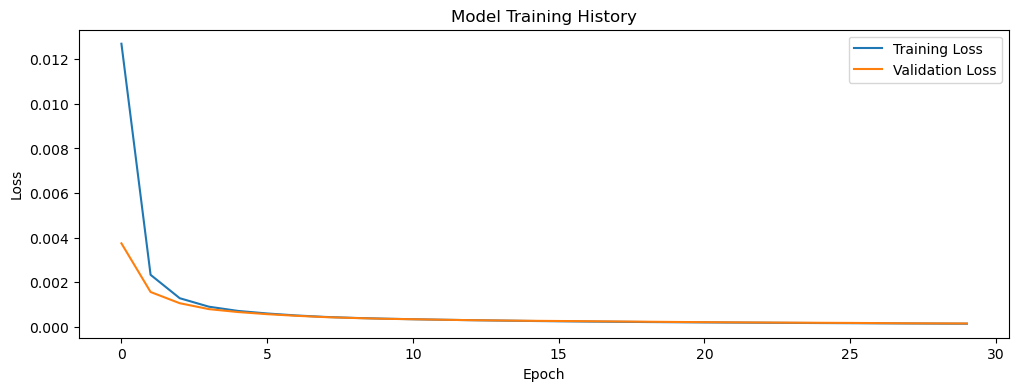

In [90]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('training_history.png')
plt.close()

In [22]:
X_test_pred = model.predict(X_test)
# Calculate reconstruction error (MSE)
mse = np.mean(np.square(X_test - X_test_pred), axis=(1, 2))

705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


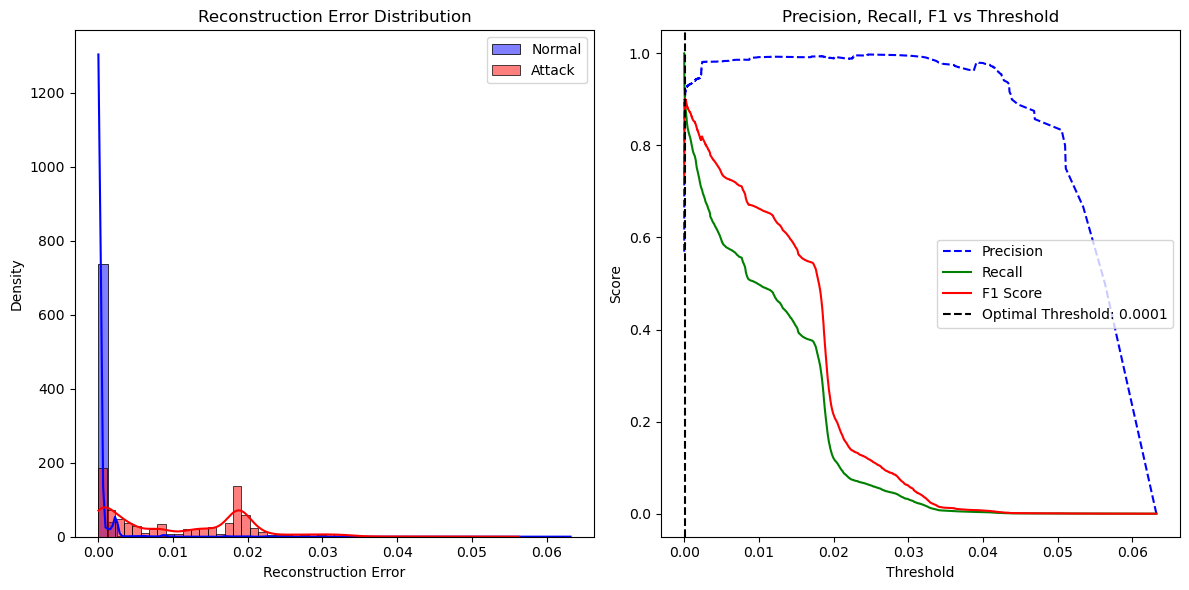

In [23]:
precision, recall, thresholds = precision_recall_curve(y_test, mse)
f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
optimal_idx = np.argmax(f1_scores)
threshold = thresholds[optimal_idx]

# Create the full figure
plt.figure(figsize=(12, 6))

# Subplot 1: Reconstruction Error Distribution
plt.subplot(1, 2, 1)
sns.histplot(mse[y_test == 0], color='blue', label='Normal', bins=50, stat="density", kde=True)
sns.histplot(mse[y_test == 1], color='red', label='Attack', bins=50, stat="density", kde=True)
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.legend()

# Subplot 2: Precision, Recall, F1 vs Threshold
plt.subplot(1, 2, 2)
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.plot(thresholds, f1_scores[:-1], 'r-', label='F1 Score')
plt.axvline(x=threshold, color='k', linestyle='--', label=f'Optimal Threshold: {threshold:.4f}')
plt.title('Precision, Recall, F1 vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
# Adjust layout and display
plt.tight_layout()
# Save before show/close
plt.savefig('threshold_determination.png')
# Show plot in notebook
plt.show()
# Optional: Close the figure (good practice if you're generating many)
plt.close()

Using threshold: 0.0001

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      9711
           1       0.90      0.90      0.90     12833

    accuracy                           0.89     22544
   macro avg       0.88      0.88      0.88     22544
weighted avg       0.89      0.89      0.89     22544



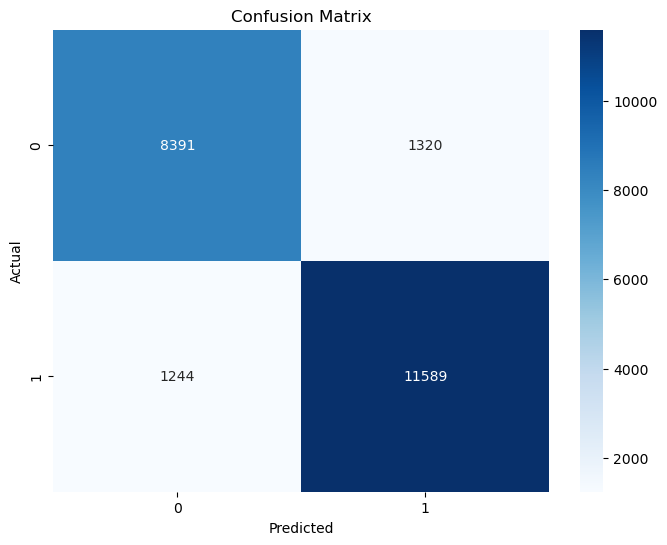

In [24]:
y_pred = (mse > threshold).astype(int)

# Model evaluation
print(f"Using threshold: {threshold:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.savefig('confusion_matrix.png')
plt.close()

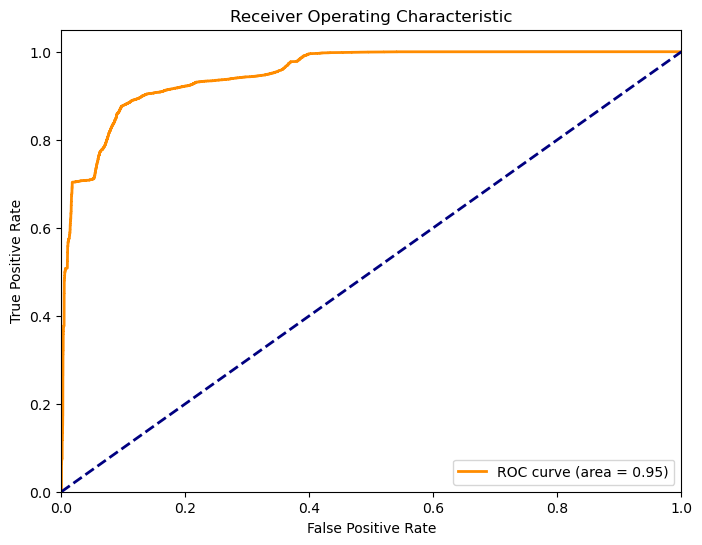

In [25]:
fpr, tpr, _ = roc_curve(y_test, mse)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
plt.savefig('roc_curve.png')
plt.close()

In [114]:
model.save(r"C:\Users\Rajat Dhanure\Downloads\CN SCE\lstm_autoencoder.keras")

In [18]:
from tensorflow.keras.models import load_model
model_path = r"C:\Users\Rajat Dhanure\Downloads\CN SCE\lstm_autoencoder.keras" 
model = load_model(model_path)
print("Model Loaded")

Model Loaded


In [19]:
X_test_normal = X_test[y_test==0]
X_test_anomaly = X_test[y_test==1]

In [26]:
def detect_anomaly(new_data):
    new_data = new_data.reshape(new_data.shape[0], 1, new_data.shape[1])
    reconstructed = model.predict(new_data)
    reconstruction_error = np.mean(np.square(new_data - reconstructed), axis=(1, 2))
    if reconstruction_error > threshold:
        print("⚠️ Anomaly Detected!")
        
    else:
        print("✅ Normal Traffic")


In [28]:
detect_anomaly(X_test_anomaly[50])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
⚠️ Anomaly Detected!
